In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import seaborn as sns

import allen_v1dd.stimulus_analysis.analysis_tools as at
from allen_v1dd.stimulus_analysis.analysis_tools import iter_plane_groups, get_roi_id

at.set_stylesheet()

%load_ext autoreload
%autoreload 2

In [2]:
at.set_analysis_file(r"/Users/chase/Desktop/stimulus_analyses_v2.h5")
at.set_included_mice(409828)
at.set_included_columns([2, 3, 4, 5])

In [3]:
# Transformation

# (row, col), in pixels, column center before tranformation
COLUMN_CENTERS = {
    1: (0, 0),
    2: (-256, -256),
    3: (256, -256),
    4: (-256, 256),
    5: (256, 256)
}

COLUMN_COLORS = {
    1: 'r',
    2: 'g',
    3: 'b',
    4: 'm',
    5: 'k'
}

PIXEL_CENTER = 255.5 # Row and col go from 0 to 511 (inclusive), so the center is at 255.5
PIXEL_TO_MICRONS = 0.78125 # 400 microns / 512 pixels
ROTATION_MATRIX = scipy.spatial.transform.Rotation.from_euler("z", -40, degrees=True).as_matrix()[:2, :2]

def column_center_pixels(pixel_points, column):
    pixel_points = np.array(pixel_points)
    orig_shape = pixel_points.shape
    pixel_points = np.atleast_2d(pixel_points)
    bias = COLUMN_CENTERS[column]
    pixel_points[:, 0] = -(pixel_points[:, 0] - PIXEL_CENTER) + bias[0] # Note: the row is subtracted here
    # roi_row_col_centered[:, 0] = roi_row_col_centered[:, 0] - PIXEL_CENTER + bias[0] # Note: the row is subtracted here
    pixel_points[:, 1] = pixel_points[:, 1] - PIXEL_CENTER + bias[1]
    return pixel_points.reshape(orig_shape)

def transform_pixels_to_microns(pixel_points, column=None, rotate=True):
    if column is not None:
        pixel_points = column_center_pixels(pixel_points, column)
    
    if rotate:
        pixel_points = np.matmul(pixel_points, ROTATION_MATRIX)

    pixel_points *= PIXEL_TO_MICRONS

    return pixel_points

In [12]:
rf_df = []

for group in iter_plane_groups(filter=dict()): # No filter - i.e., include all plane groups
    inclusion = group["is_roi_valid"][()] & ~group["is_ignored_duplicate"][()]
    lsn = group["locally_sparse_noise"]
    best_rf_dist = np.full(len(inclusion), np.nan, dtype=float)
    best_rf_center = np.full((len(inclusion), 2), np.nan, dtype=float)
    column = group.attrs["column"]
    depth = group.attrs["plane_depth_microns"]
    roi_centroids = group["roi_centroids"]

    for onoff in range(2):
        responsive = inclusion & lsn["is_responsive"][:, onoff]
        rf_centers = lsn["rf_centers"][:, onoff]
        rf_centers[~responsive] = np.nan
        rf_dist = rf_centers.copy()
        rf_dist = np.linalg.norm(rf_dist, axis=1)
        update_mask = np.isnan(best_rf_dist) | (rf_dist < best_rf_dist)
        best_rf_dist[update_mask] = rf_dist[update_mask]
        best_rf_center[update_mask] = rf_centers[update_mask]

    for roi in np.where(inclusion)[0]:
    # for roi in np.where(np.isfinite(best_rf_dist))[0]:
        rf_df.append(dict(
            roi_id = get_roi_id(group, roi),
            column = column,
            depth = depth,
            roi_position_px = roi_centroids[roi],
            rf_dist = best_rf_dist[roi],
            rf_center_azi = best_rf_center[roi, 0],
            rf_center_alt = best_rf_center[roi, 1]
        ))

rf_df = pd.DataFrame(rf_df)
rf_df["has_rf"] = ~rf_df["rf_dist"].isna()
rf_df["roi_position_px_centered"] = rf_df.apply(lambda row: column_center_pixels(row["roi_position_px"], row["column"]), axis=1)
rf_df["roi_position_microns"] = list(transform_pixels_to_microns(np.vstack(rf_df["roi_position_px_centered"])))
rf_df

,roi_id,column,depth,roi_position_px,rf_dist,rf_center_azi,rf_center_alt,has_rf,roi_position_px_centered,roi_position_microns
0,M409828_11_0_89,1,50,"[257.625, 496.67788461538464]",8.419019,2.158929,-8.137500,True,"[-2.125, 241.17788461538464]","[-122.3859378146929, 143.27113643923562]"
1,M409828_11_1_2,1,66,"[101.85317460317461, 182.21825396825398]",NaN,NaN,NaN,False,"[153.6468253968254, -73.28174603174602]","[128.7538243464938, 33.30093851802749]"
2,M409828_11_1_4,1,66,"[262.0169491525424, 496.2401129943503]",0.413919,-0.301246,0.283866,True,"[-6.516949152542395, 240.74011299435028]","[-124.7945581810155, 140.80360283355117]"
3,M409828_11_1_159,1,66,"[108.86124401913875, 266.94736842105266]",NaN,NaN,NaN,False,"[146.63875598086125, 11.447368421052659]","[82.01060748472577, 80.48966282158484]"
4,M409828_11_2_0,1,82,"[171.4820512820513, 142.03076923076924]",NaN,NaN,NaN,False,"[84.01794871794871, -113.46923076923076]","[107.26413934122192, -25.716232241076327]"
...,...,...,...,...,...,...,...,...,...,...
112735,M438833_55_5_195,5,514,"[254.8695652173913, 300.7782608695652]",NaN,NaN,NaN,False,"[256.6304347826087, 301.2782608695652]","[2.290926051218145, 309.1807822800083]"
112736,M438833_55_5_212,5,514,"[99.83720930232558, 410.6279069767442]",NaN,NaN,NaN,False,"[411.66279069767444, 411.1279069767442]","[39.909428634213384, 452.7765545157182]"
112737,M438833_55_5_218,5,514,"[91.07453416149069, 452.30434782608694]",NaN,NaN,NaN,False,"[420.4254658385093, 452.80434782608694]","[24.224662075386718, 482.11916774216564]"
112738,M438833_55_5_224,5,514,"[11.964539007092199, 382.9078014184397]",NaN,NaN,NaN,False,"[499.5354609929078, 383.4078014184397]","[106.41920298872178, 480.31454738309]"


In [5]:
dg_df = []

# for group in iter_plane_groups(filter=dict(column=[2, 3, 4, 5])):
for group in iter_plane_groups():
    inclusion = group["is_roi_valid"][()] & ~group["is_ignored_duplicate"][()]

    for dg_type in ("windowed", "full"):
        dg = group[f"drifting_gratings_{dg_type}"]
        is_responsive = inclusion & (dg["frac_responsive_trials"][()] >= 0.25)
        trial_mean_responses = np.nanmean(dg["trial_responses"][()], axis=3)
        pref_cond_index = dg["pref_cond_index"][()]

        for roi in np.where(inclusion)[0]:
            pref_dir_idx, pref_sf_idx = pref_cond_index[roi]
            mean_pref_resp = trial_mean_responses[roi, pref_dir_idx, pref_sf_idx]
            mean_resp = np.nanmean(trial_mean_responses[roi, :, pref_sf_idx])

            dg_df.append(dict(
                roi_id = get_roi_id(group, roi),
                dg_type = dg_type,
                is_responsive = is_responsive[roi],
                mean_pref_resp = mean_pref_resp,
                mean_resp = mean_resp,
                pref_dir_idx = pref_dir_idx,
                pref_sf_idx = pref_sf_idx
            ))


dg_df = pd.DataFrame(dg_df)
dg_df

,roi_id,dg_type,is_responsive,mean_pref_resp,mean_resp,pref_dir_idx,pref_sf_idx
0,M409828_21_0_0,windowed,True,0.006086,0.003172,2,0
1,M409828_21_0_1,windowed,True,0.005508,0.002744,3,0
2,M409828_21_0_4,windowed,True,0.007442,0.003498,8,0
3,M409828_21_0_149,windowed,True,0.005021,0.003067,0,0
4,M409828_21_0_0,full,True,0.004318,0.002352,2,0
...,...,...,...,...,...,...,...
45405,M409828_55_5_55,full,True,0.001052,0.000597,5,0
45406,M409828_55_5_67,full,True,0.000887,0.000430,8,0
45407,M409828_55_5_73,full,True,0.001283,0.000668,4,0
45408,M409828_55_5_74,full,True,0.000739,0.000358,10,1


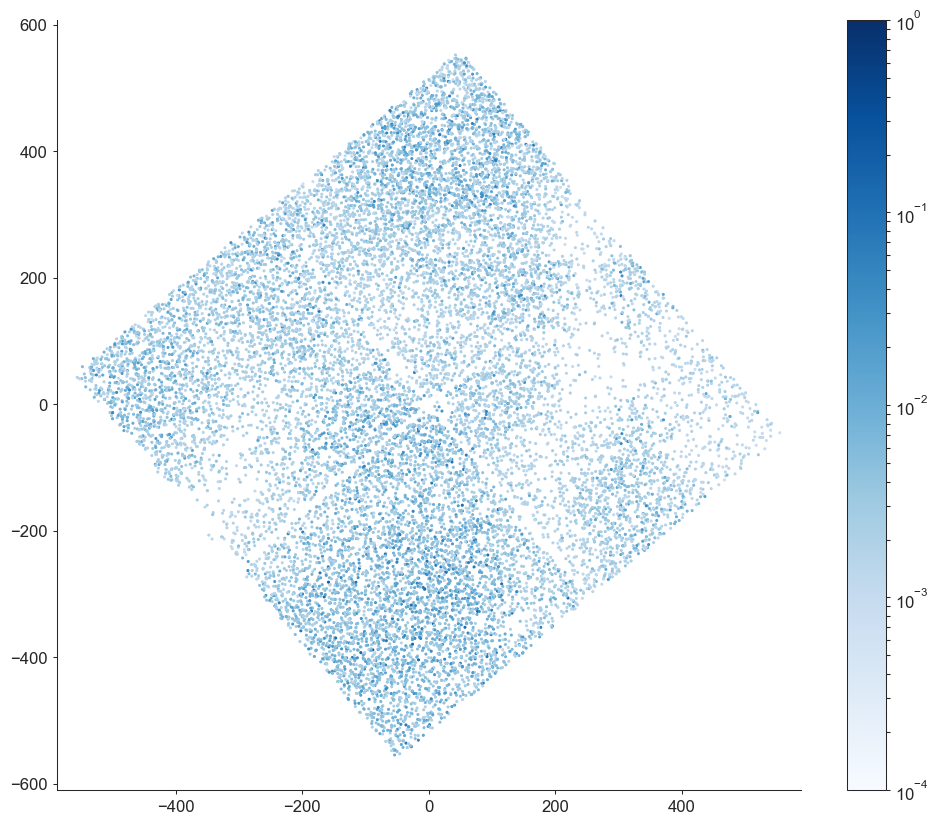

In [8]:
df = dg_df[dg_df.is_responsive].merge(rf_df, how="inner", on="roi_id")
df = df[df.dg_type == "windowed"]

pos = np.vstack(df.roi_position_microns.values)
resp = df.mean_pref_resp
# resp = df.mean_resp

plt.figure(figsize=(12, 10))
plt.scatter(pos[:, 0], pos[:, 1], c=resp, cmap="Blues", norm=mpl.colors.LogNorm(vmin=1e-4, vmax=1), s=2)
# plt.scatter(pos[:, 0], pos[:, 1], c=df.pref_sf_idx, cmap="jet", s=2)
plt.axis("equal")
plt.colorbar()

In [6]:
def horiz_point_plot_ci(df, x, y, hue, ax, n_boot=1000):
    df_conf = df.groupby([hue, y]).aggregate(
        x = pd.NamedAgg(x, "mean"),
        ci = pd.NamedAgg(x, lambda data: tuple(sns.utils.ci(sns.algorithms.bootstrap(data.astype(float), n_boot=n_boot))))
    )
    df_conf = df_conf.reset_index()
    
    for hue_val in df_conf[hue].unique():
        df_sub = df_conf[df_conf[hue] == hue_val]

        x_vals = df_sub["x"].values
        y_vals = df_sub[y].values
        ci = np.vstack(df_sub["ci"].values).T
        ci[0] = x_vals - ci[0] # lower error, relative to mean
        ci[1] = ci[1] - x_vals # upper error

        ax.errorbar(x=x_vals, y=y_vals, xerr=ci, label=hue_val, marker=".", markersize=10)
    
    ax.legend(title=hue)

In [24]:
np.floor(df.depth / 100) * 100

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
         ...  
45405    500.0
45406    500.0
45407    500.0
45408    500.0
45409    500.0
Name: depth, Length: 45410, dtype: float64

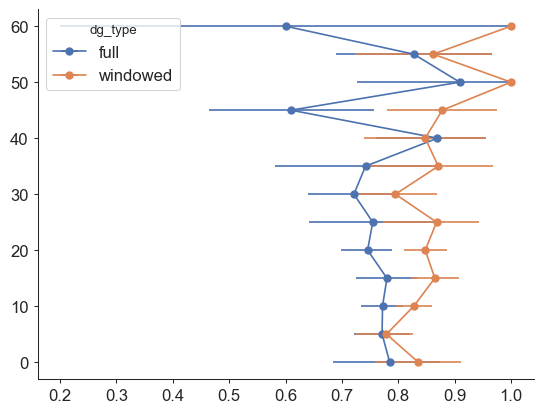

In [33]:
df = dg_df.merge(rf_df, how="inner", on="roi_id")
df["roi_radial_dist"] = df.roi_position_microns.apply(np.linalg.norm)
df["roi_radial_dist_bins"] = np.floor(df["roi_radial_dist"] / 25) * 25
df["rf_dist_bins"] = np.floor(df["rf_dist"] / 5) * 5
fig, ax = plt.subplots()
# horiz_point_plot_ci(df, x="is_responsive", y="roi_radial_dist_bins", hue="dg_type", ax=ax)
horiz_point_plot_ci(df[(np.floor(df.depth / 100) * 100) == 300], x="is_responsive", y="rf_dist_bins", hue="dg_type", ax=ax)

In [15]:
df[df.is_responsive & (df.depth < 375)].groupby("dg_type")["rf_dist_bins"].value_counts().sort_index()

dg_type   rf_dist_bins
full      0.0             469
          5.0             761
          10.0            964
          15.0            561
          20.0            640
          25.0            156
          30.0            270
          35.0             90
          40.0            107
          45.0             79
          50.0             23
          55.0            111
          60.0             11
windowed  0.0             410
          5.0             655
          10.0            924
          15.0            543
          20.0            637
          25.0            140
          30.0            251
          35.0             90
          40.0             95
          45.0             84
          50.0             22
          55.0             99
          60.0             10
Name: rf_dist_bins, dtype: int64

Text(0, 0.5, 'Imaging depth (µm)')

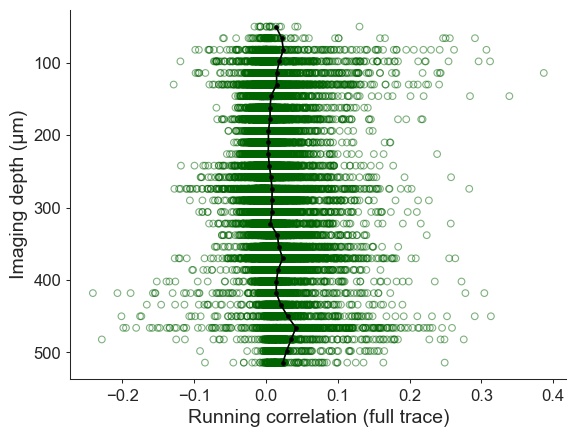

In [35]:
depth = []
run_corr = []

for group in iter_plane_groups():
    inclusion = group["is_roi_valid"][()] & ~group["is_ignored_duplicate"][()]
    d = group.attrs["plane_depth_microns"]
    run_corrs = group["running_correlations"]

    for roi in np.where(inclusion)[0]:
        depth.append(d)
        run_corr.append(run_corrs[roi])

depth = np.array(depth)
run_corr = np.array(run_corr)

plt.scatter(run_corr, depth, alpha=0.5, marker="o", facecolors="none", edgecolors="darkgreen")

depths = np.unique(depth)
mean_run_corrs = [np.mean(run_corr[depth == d]) for d in depths]
plt.plot(mean_run_corrs, depths, marker=".", color="black")

plt.gca().invert_yaxis()
plt.xlabel("Running correlation (full trace)")
plt.ylabel("Imaging depth (µm)")

In [100]:
ssi_df = []

for group in iter_plane_groups():
    dgw = group["drifting_gratings_windowed"]
    dgf = group["drifting_gratings_full"]
    inclusion = group["is_roi_valid"][()] & ~group["is_ignored_duplicate"][()] # & ((dgw["frac_responsive_trials"][()] >= 0.25) | (dgf["frac_responsive_trials"][()] >= 0.25))
    inclusion = group["is_roi_valid"][()] & ~group["is_ignored_duplicate"][()] & (dgw["frac_responsive_trials"][()] >= 0.25)
    depth = group.attrs["plane_depth_microns"]
    ssi = group["ssi"]["ssi"][()]
    
    for roi in np.where(inclusion)[0]:
        ssi_df.append(dict(
            roi_id = get_roi_id(group, roi),
            depth = depth,
            ssi = ssi[roi],
            dgw_pref_dir = dgw["pref_cond"][roi, 0],
            dgf_pref_dir = dgf["pref_cond"][roi, 0],
        ))

ssi_df = pd.DataFrame(ssi_df)
ssi_df["depth_trunc"] = (ssi_df.depth / 100).astype(int) * 100
ssi_df

,roi_id,depth,ssi,dgw_pref_dir,dgf_pref_dir,depth_trunc
0,M409828_21_0_0,50,0.169997,60.0,60.0,0
1,M409828_21_0_1,50,0.315031,90.0,240.0,0
2,M409828_21_0_4,50,-0.409028,240.0,240.0,0
3,M409828_21_0_149,50,0.108027,0.0,30.0,0
4,M409828_21_1_0,66,-0.215402,300.0,300.0,0
...,...,...,...,...,...,...
16358,M409828_55_5_49,514,0.775063,270.0,300.0,500
16359,M409828_55_5_52,514,0.657628,120.0,30.0,500
16360,M409828_55_5_55,514,0.508338,150.0,150.0,500
16361,M409828_55_5_67,514,0.733587,150.0,240.0,500


In [101]:
ssi_df.groupby("depth").ssi.mean().sort_index()

depth
50     0.272619
66     0.318995
82     0.420077
98     0.406875
114    0.417883
130    0.425001
146    0.411418
162    0.407577
178    0.427880
194    0.402890
210    0.407610
226    0.407361
242    0.393550
258    0.367474
274    0.407952
290    0.376181
306    0.384963
322    0.389907
338    0.467068
354    0.458359
370    0.508042
386    0.432102
402    0.380521
418    0.408057
434    0.381621
450    0.390498
466    0.411569
482    0.341674
498    0.373837
514    0.386513
Name: ssi, dtype: float64

Text(0, 0.5, 'Imaging depth (µm)')

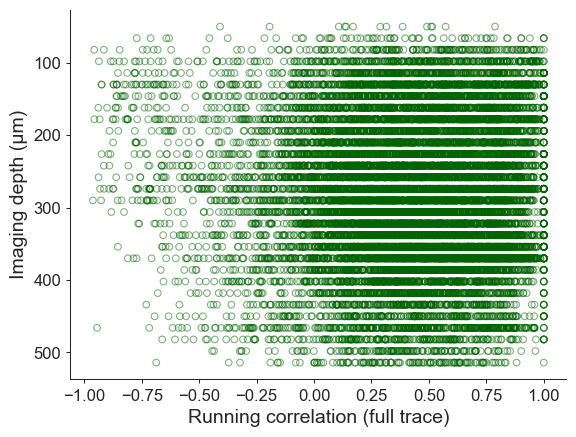

In [102]:
plt.scatter(ssi_df.ssi, ssi_df.depth, alpha=0.5, marker="o", facecolors="none", edgecolors="darkgreen")
plt.gca().invert_yaxis()
plt.xlabel("Running correlation (full trace)")
plt.ylabel("Imaging depth (µm)")

In [110]:
df = ssi_df.merge(rf_df, how="left", on="roi_id")
df = df[df.rf_dist <= 5]
df

,roi_id,depth,ssi,dgw_pref_dir,dgf_pref_dir,depth_trunc,column,roi_position_px,rf_dist,rf_center_azi,rf_center_alt,has_rf,roi_position_px_centered,roi_position_microns
14,M409828_21_1_24,66,0.129051,270.0,60.0,0,2,"[322.2930402930403, 35.43223443223443]",1.962902,1.953316,-0.193750,True,"[-322.7930402930403, -476.0677655677656]","[45.888004909493695, -447.0128384020855]"
15,M409828_21_1_25,66,0.333959,90.0,240.0,0,2,"[214.5590909090909, 160.01818181818183]",4.842804,4.841234,-0.123295,True,"[-215.0590909090909, -351.4818181818182]","[47.79948142518868, -318.3500098924622]"
27,M409828_21_2_5,82,0.183033,300.0,0.0,0,2,"[80.64935064935065, 227.89935064935065]",3.182073,2.878571,-1.356250,True,"[-81.14935064935065, -283.60064935064935]","[93.85232372969203, -210.47851455586698]"
62,M409828_21_2_46,82,-0.149558,240.0,240.0,0,2,"[260.2262443438914, 220.1447963800905]",2.970989,-0.616837,2.906250,True,"[-260.7262443438914, -291.3552036199095]","[-9.725293554954927, -305.2989328837411]"
66,M409828_21_2_55,82,0.493030,270.0,30.0,0,2,"[231.58796296296296, 264.88425925925924]",2.775182,-2.158929,-1.743750,True,"[-232.08796296296296, -246.61574074074076]","[-15.053243625597613, -264.1420974453876]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16126,M409828_55_1_119,450,0.508702,60.0,120.0,400,5,"[148.93243243243242, 455.1756756756757]",4.723242,2.398810,4.068750,True,"[362.5675675675676, 455.6756756756757]","[-11.843599976223862, 454.7826244706693]"
16192,M409828_55_2_64,466,0.473103,180.0,150.0,400,5,"[207.20448179271708, 393.484593837535]",4.068750,0.000000,-4.068750,True,"[304.29551820728295, 393.984593837535]","[-15.737909794884564, 388.5992949769668]"
16215,M409828_55_2_100,466,0.493997,300.0,90.0,400,5,"[395.919881305638, 430.026706231454]",1.939649,1.850510,-0.581250,True,"[115.580118694362, 430.526706231454]","[-147.02947245616198, 315.7000462076231]"
16249,M409828_55_2_229,466,0.114119,120.0,30.0,400,5,"[278.103734439834, 496.8215767634855]",3.407223,-1.136278,-3.212171,True,"[233.396265560166, 497.3215767634855]","[-110.06268382519933, 414.83957654064085]"


<Axes: xlabel='dgw_pref_dir', ylabel='ssi'>

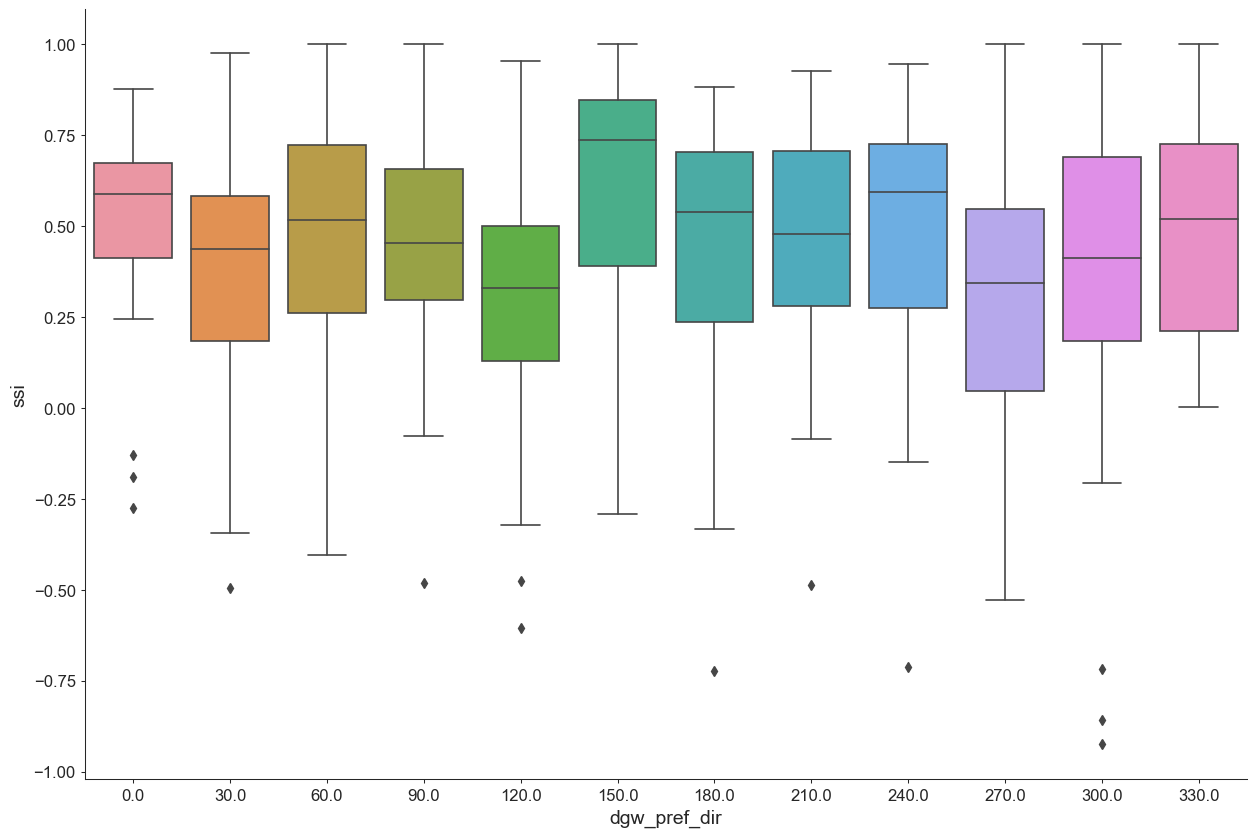

In [114]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=df, x="dgw_pref_dir", y="ssi")